In [2]:
import numpy as np
import pandas as pd
import pygimli as pg
from pygimli.physics import ert
import matplotlib.pyplot as plt


In [156]:
# load data file (already in BERT unified data format)

# data_in = ert.load('data_unified/CER2017-08-24_u_i.txt') 
# data_in = ert.load('data_unified/craterlake_2019_feb6.txt') 
data_in = ert.load('data_unified/craterlake_2019_may3.txt') 
# data_in = ert.load('data_unified/fieldschool_wen3_2013_aug26.txt') # no permafrost. bad electrode to test filtering
# data_in = ert.load('data_unified/oldcrow_wen13_2013_oct14.txt') 
# data_in = ert.load('data_unified/oldcrow_wen1_2013_oct13.txt')  
# data_in = ert.load('data_unified/SCH2018-08-29_u_i.txt') 
# data_in = ert.load('data_unified/Teller_ERTB_2019-10-03_0600.ohm') # data from the seward peninsula
# data_in = ert.load('data_unified/2001_ALK_2019-10-03_0600_fr.ohm') # seward peninsula summer
# data_in = ert.load('data_unified/2001_ALK_2020-02-01_1000_fr.ohm') # seward peninsula winter


print(data_in)

Data: Sensors: 128 data: 9187, nonzero entries: ['a', 'b', 'm', 'n', 'r', 'valid']


In [157]:
# calculate geometric factor and apparent resistivity if not already in data file

if data_in.haveData('k')==False:
    data_in['k'] = ert.createGeometricFactors(data_in,numerical=True) # include topo in k calculation
    
if data_in.haveData('rhoa')==False:
    if data_in.haveData('r')==False:
        data_in['rhoa'] = (data_in['u']/data_in['i'])*data_in['k'] 
    else:
        data_in['rhoa'] = data_in['r']*data_in['k']


04/10/21 - 16:55:27 - pyGIMLi - INFO - Cache /Users/teddiherringnew/anaconda/envs/idgsp/lib/python3.8/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (13.4s x 3): /Users/teddiherringnew/Library/Caches/pygimli/18293058136181886782


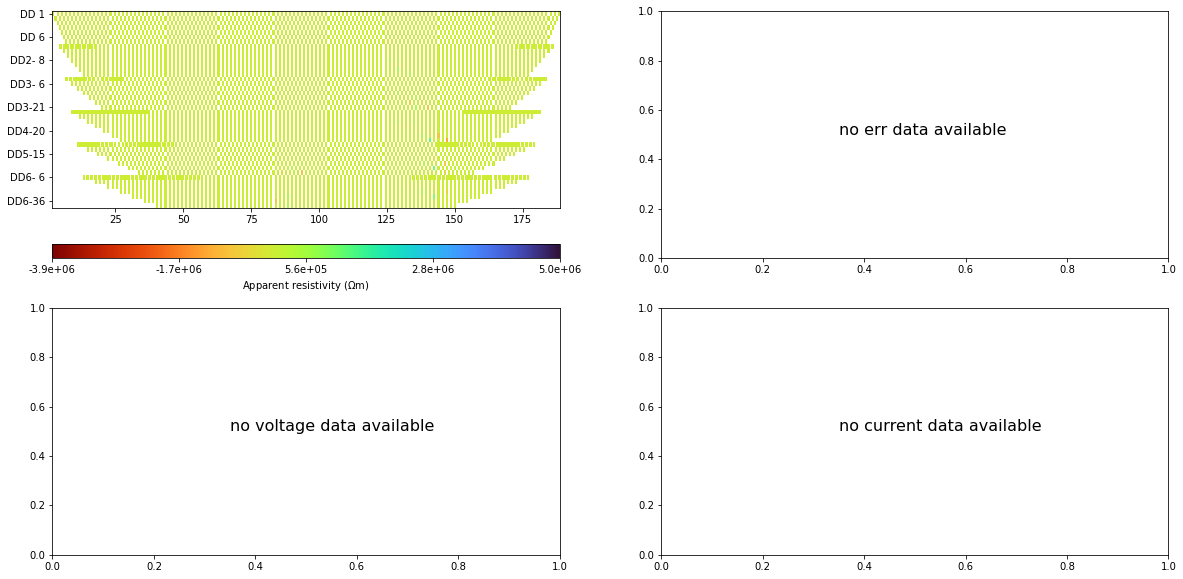

In [158]:
# plot raw data 

mgr = ert.ERTManager(data_in)

fig, ax = plt.subplots(2,2,figsize=[20,10])

mgr.showData(data_in, vals=data_in['rhoa'],ax=ax[0,0],label=r'Apparent resistivity ($\Omega$m)',cMap='turbo_r');

if data_in.haveData('err'):
    mgr.showData(data_in, vals=data_in['err'],ax=ax[0,1],label='Standard deviation (%)',cMap='plasma');
else:
    ax[0,1].text(0.35,0.5,'no err data available',fontsize=16)
    
if data_in.haveData('u'):
    mgr.showData(data_in, vals=data_in['u'],ax=ax[1,0],label='Voltage (V)',cMap='plasma');
else:
    ax[1,0].text(0.35,0.5,'no voltage data available',fontsize=16)
    
if data_in.haveData('i'):
    mgr.showData(data_in, vals=data_in['i'],ax=ax[1,1],label='Current (A)',cMap='plasma');
else:
    ax[1,1].text(0.35,0.5,'no current data available',fontsize=16)

In [159]:
# put data into pandas dataframe

df = pd.DataFrame(np.array(data_in.dataMap()).T)
header = df.iloc[0]
df = df[1:] 
df.columns = header
df = df.apply(pd.Series.explode).reset_index()

data_raw = pd.DataFrame(df)

/var/folders/5z/g4c125y952l233l_4lb9yt6c0000gp/T/ipykernel_1153/2495968878.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  df = pd.DataFrame(np.array(data_in.dataMap()).T)


In [160]:
# step 1. technical filter

data_tf = data_raw.copy()

I = (np.unique(np.hstack([ 
    np.where(data_tf['rhoa'] < 0)[0],
    np.where(data_tf['err'] > 10)[0],
    np.where(data_tf['rhoa'] > 9*np.std(data_tf['rhoa']))[0]
])))

data_tf = data_tf.drop(I)
n_tf = len(I)

In [161]:
# to apply a moving median filter we will need to sort our data by depth level and array midpoint. 

# find midpoint of array

mp = np.mean([data_tf['a'],data_tf['b'],data_tf['m'],data_tf['n']],axis=0)

# sort by depth level and midpoint so we can apply moving median filter
# note: this works for 2D lines with topography and even electrode spacing

# to find unique depth levels, check to find unique relative positions of electrodes

ab = data_tf['a'] - data_tf['b']
am = data_tf['a'] - data_tf['m']
an = data_tf['a'] - data_tf['n']

# pos is just a placeholder variable describing relative electrode positions...

pos = (np.array([ab,am,an]).T).astype(dtype=float)
pos_uniq = np.unique(pos, axis=0)

# ...and we'll add this info to dataframe for convenience

pos_i = []
for i in range(len(pos)):
    pos_i.append(np.where((pos[i]==pos_uniq).all(axis=1))[0][0])

data_tf['pos'] = pos_i

# sort by depth level

sort_index = np.argsort(pos)
i_all = np.linspace(0,len(pos),len(pos)+1).astype('int')
sort_index = np.array([])

# sort by midpoint

for i in range(len(pos_uniq)):
    j = np.where((pos==pos_uniq[i]).all(axis=1))
    si = np.argsort(mp[j])
    sort_index = np.append(sort_index,i_all[j][si]) 

sort_index = sort_index.astype('int')

# make a dataframe with sorted values

data_sort = pd.DataFrame(columns = data_tf.columns)
for i in range(len(data_tf)):
    data_sort = data_sort.append(data_tf.iloc[sort_index[i]])
data_sort = data_sort.reset_index()

In [162]:
# step 2. moving median filter

data_filt = data_sort.copy()

th = 0.5 # threshold for filter TODO: make this higher for shallower data
n_mmf = 0 # keeping track of how many data are removed

ikeep = np.ones(data_filt.shape[0],dtype=bool)

k=0

for j in range(len(pos_uniq)): # loop through each unique depth level
    I = (np.where(data_filt['pos']==k)[0])
    
    # moving median of data points
    
    mm = [] 
    r = np.array(data_filt['rhoa'],dtype=np.float)[I]
   
    for i in range(len(I)): # loop through depth level from left to right
        if i==0:
            mm.append(np.median(r[i:3])) # end points only use two neighboring data points to calculate median
        elif i==1:
            mm.append(np.median(r[i-1:4])) 
        elif i==len(r)-2:
            mm.append(np.median(r[i-2:])) 
        elif i==len(r)-1:
            mm.append(np.median(r[i-2:])) 
        else:
            mm.append(np.median(r[i-2:i+3])) 
    
    ithrow = np.where(abs(r-mm)/mm > th)[0]
    n_mmf = n_mmf + len(ithrow)
    
    # get rid of outlier data 
    
    for i in range(len(ithrow)):
        ikeep[I[ithrow[i]]] = 0
        
    k=k+1     

print('data points removed by technical filter = %.0f'%n_tf)
print('data points removed by moving median filter = %.0f'%n_mmf)

data_filt = data_filt[ikeep]

data points removed by technical filter = 192
data points removed by moving median filter = 324


In [163]:
# put everything back into the pygimli data container

data_out = pg.DataContainerERT()

# sensors are the same

for i in range(0,len(data_in.sensors())):
    data_out.createSensor(np.array(data_in.sensors()[i])) # 2D, no topography

# add filtered quadripoles and data 

cols = data_filt.columns
for i in range(len(cols)):
    if max(data_filt[cols[i]]) > 0:
        data_out[cols[i]] = np.array(data_filt[cols[i]])

516 data points removed (5.6% of the data)


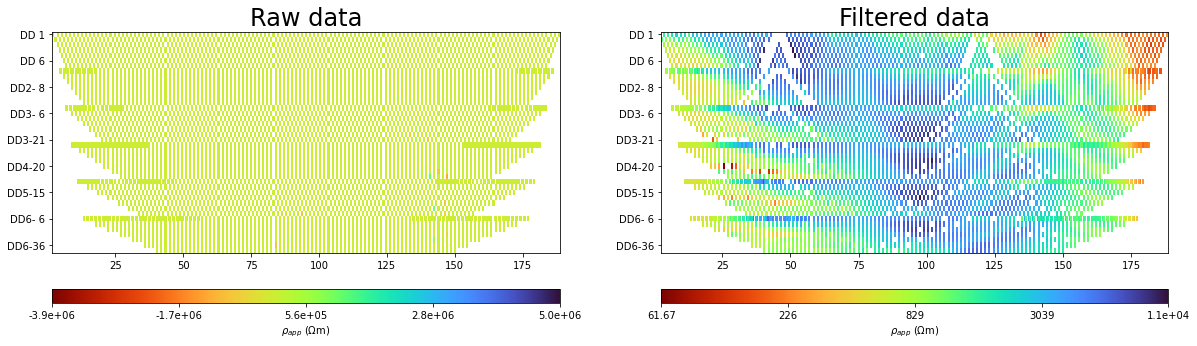

In [164]:
# plot filtered data

fig, ax = plt.subplots(1,2,figsize=[20,5])

mgr.showData(data_in, vals=data_in['rhoa'],ax=ax[0],label=r'$\rho_{app}$ ($\Omega$m)',cMap='turbo_r');
ax[0].set_title('Raw data',fontsize=24);

mgr.showData(data_out, vals=data_out['rhoa'],ax=ax[1],label=r'$\rho_{app}$ ($\Omega$m)',cMap='turbo_r');
ax[1].set_title('Filtered data',fontsize=24);

print('%.0f data points removed (%.1f%% of the data)'%(n_tf+n_mmf, float((data_in.size()-data_out.size())/data_in.size()*100)))

In [165]:
# first pass inversion

# assume simple noise model for now
# TODO: incorporate measurement errors if known

data_out['err'] = ert.estimateError(
    data_out, 
    absoluteUError=0.00005, # 50µV
    relativeError=0.05 # % noise
)  

# set wether lambda is being optimized by L-curve

mgr.inv.inv.setOptimizeLambda(True)


# run inversion

mod = mgr.invert(
    data_out,
    blockyModel=True, 
    verbose=True, 
    robustData=True, # can use robust data constraint 
#     lam = 20, # can change regularization parameter
#     paraMaxCellSize=10, # can change the maximum cell area
#     zWeight=0.3 # can change the ratio of smoothness_z / smoothness_x
)

# getting lambda, chi2, rms error

lam = mgr.inv.inv.getLambda()
chi2 = mgr.inv.inv.getChi2()
rms = np.sqrt(np.mean(((data_out['rhoa']-mgr.inv.response)/data_out['rhoa'])**2))*100

04/10/21 - 16:56:04 - pyGIMLi - INFO - Found 2 regions.
04/10/21 - 16:56:04 - pyGIMLi - INFO - Region with smallest marker (1) set to background
04/10/21 - 16:56:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
04/10/21 - 16:56:04 - Core - WARNING - Region Nr: 1  is background and should not get a model transformation.
04/10/21 - 16:56:04 - Core - WARNING - Region Nr: 1  is background and should not get a model control.
04/10/21 - 16:56:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
04/10/21 - 16:56:04 - pyGIMLi - INFO - Starting inversion.
04/10/21 - 16:56:04 - pyGIMLi - INFO - Set default startmodel to median(data values)=2046.4649523208514
04/10/21 - 16:56:04 - pyGIMLi - INFO - Created startmodel from forward operator: 1844 [2046.4649523208514,...,2046.4649523208514]


Constructing Delaunay triangulation by divide-and-conquer method.
Delaunay milliseconds:  0
Recovering segments in Delaunay triangulation.
Segment milliseconds:  0
Removing unwanted triangles.
Spreading regional attributes and area constraints.
Hole milliseconds:  0
Adding Steiner points to enforce quality.
Quality milliseconds:  1

Writing vertices.
Writing triangles.
Writing segments.
Writing edges.

Output milliseconds:  0
Total running milliseconds:  1

Statistics:

  Input vertices: 263
  Input segments: 264
  Input holes: 0

  Mesh vertices: 1239
  Mesh triangles: 2177
  Mesh edges: 3415
  Mesh exterior boundary edges: 299
  Mesh interior boundary edges: 28
  Mesh subsegments (constrained edges): 327

min/max(dweight) = 12.3058/19.999
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x174bed450>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x165e85720>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x165e85ae0>
min/max (data): 61.67/1.1e+

In [137]:
mgr.fw.run

Text(0.5, 1.0, 'Misfit')

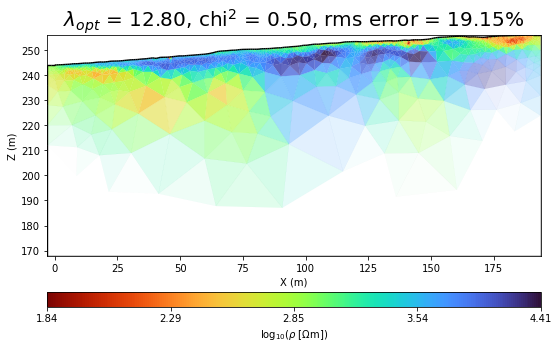

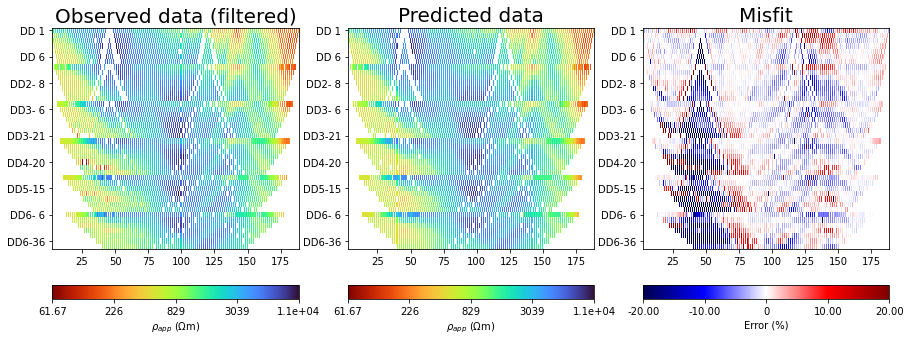

In [166]:
# plot results

fig, ax = plt.subplots(1,1,figsize=[15,5])

ax, cBar = mgr.showResult(
    np.log10(mod),
    ax=ax,
    cMap='turbo_r',
    coverage=mgr.coverage()

);

cBar.set_label(r'log$_{10}$($\rho$ [$\Omega$m])')
ax.set_xlabel('X (m)')
ax.set_ylabel('Z (m)')
ax.set_title(r'$\lambda_{opt}$ = %.2f, chi$^2$ = %.2f, rms error = %.2f%%'%(lam,chi2,rms),fontsize=20);


fig, ax = plt.subplots(1,3,figsize=[15,5])
mgr.showData(data_out, vals=data_out['rhoa'],ax=ax[0],label=r'$\rho_{app}$ ($\Omega$m)',cMap='turbo_r');
mgr.showData(data_out, vals=mgr.inv.response,ax=ax[1],label=r'$\rho_{app}$ ($\Omega$m)',cMap='turbo_r',cMin=min(data_out['rhoa']),cMax=max(data_out['rhoa']));
mgr.showData(data_out, vals=((mgr.inv.response-data_out['rhoa'])/data_out['rhoa'])*100,ax=ax[2],label='Error (%)',cMap='seismic',cMin=-20,cMax=20);
ax[0].set_title('Observed data (filtered)',fontsize=20)
ax[1].set_title('Predicted data',fontsize=20)
ax[2].set_title('Misfit',fontsize=20)

04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially t

04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially t

04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially t

04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially t

04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially t

04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially t

04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially t

04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially t

04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially t

04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially t

04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially t

04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:03 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially t

04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially t

04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially t

04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially t

04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially t

04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially t

04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially t

04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially t

04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
04/10/21 - 17:01:04 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially t

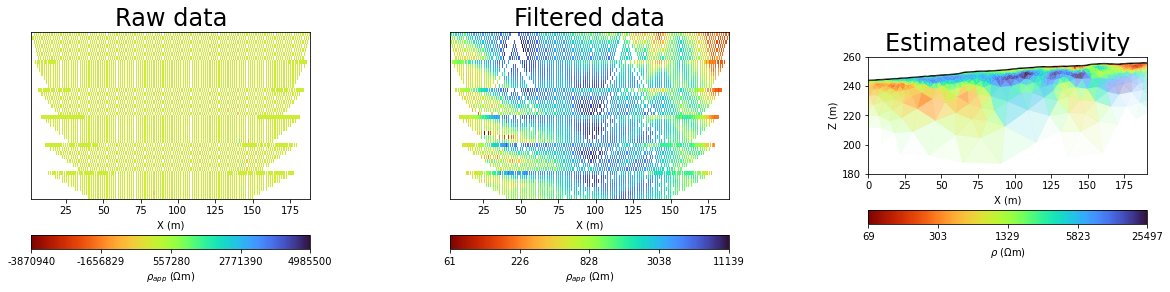

In [167]:
fig, ax = plt.subplots(1,3,figsize=[20,4])

a,b = mgr.showData(data_in, vals=data_in['rhoa'],ax=ax[0],label=r'$\rho_{app}$ ($\Omega$m)',cMap='turbo_r');
ax[0].set_title('Raw data',fontsize=24);
ax[0].set_yticks([])
ax[0].set_xlabel('X (m)')
bounds = a[1].get_ticks()
bound_labels = [int(v) if v <=100 else str(int(v)) for v in bounds]
a[1].set_ticklabels(bound_labels)

a,b = mgr.showData(data_out, vals=data_out['rhoa'],ax=ax[1],label=r'$\rho_{app}$ ($\Omega$m)',cMap='turbo_r');
ax[1].set_title('Filtered data',fontsize=24);
ax[1].set_yticks([])
ax[1].set_xlabel('X (m)')
bounds = a[1].get_ticks()
bound_labels = [int(v) if v <=100 else str(int(v)) for v in bounds]
a[1].set_ticklabels(bound_labels)

a,b = mgr.showResult(mod, ax=ax[2],label=r'$\rho$ ($\Omega$m)',cMap='turbo_r',coverage=mgr.coverage(),           );
ax[2].set_xlabel('X (m)')
ax[2].set_ylabel('Z (m)')
# ax[2].set_ylim([-40,5])
# ax[2].set_ylim([-3.8,0])
ax[2].set_ylim([180,260])
ax[2].set_title('Estimated resistivity',fontsize=24);
bounds = b.get_ticks()
bound_labels = [int(v) if v <=100 else str(int(v)) for v in bounds] # format(v,'.1E')
b.set_ticklabels(bound_labels)
ax[2].set_xlim([min(np.array(data_in.sensors()).T[0]),max(np.array(data_in.sensors()).T[0])])
# for a in ax:
#     a.set_yticks([])
plt.subplots_adjust(wspace=0.5)
